## 05 - Individual Asset Performance
Using the `get_ticker_timeseries()` function defined in chapter 03, I can retrieve the time series of my assets from the transactions DataFrame and calculate various performance metrics per each asset.

**Objective:**

In this notebook, I aim to compute the following **performance** metrics per each asset:
- Total Return, Annual Return, Annual Volatility, Sharpe Ratio;
- Periods of **maximum drawdown**;
- Asset **Total Return Index (TRI)** and **Active Investment Return Index (AIRI)** discussed in chapter 03;
- Asset **Price-to-Fiscal Price Ratio**.

From `utils.py` I'm using the `apply_plot_config()` function defined in chapter 04 for this notebook to apply a predefined consistent visual style to all plots.

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# import the function apply_plot_config() for plot default configuration
from utils import apply_plot_config 
# Apply the default configuration for plots
apply_plot_config()

In [2]:
# importing the necessary functions from utils
from utils import load_transactions, get_ticker_timeseries

In [3]:
# Loading the Portfolio Transactions
excel_path = '../data/transactions_carlo.xlsx'
df_transacts = load_transactions(excel_path=excel_path, sheet_name=0)

#### A. Generating the data for asset performance analysis

In [4]:
# Creating the dictionary with asset timeseries DataFrames
assets = {}
for asset in df_transacts['Ticker'].unique():
    assets[asset] = get_ticker_timeseries(transactions=df_transacts, ticker=asset)

# creating the asset airi and tri Dataframe    
airi = {}
tri ={}
for asset in df_transacts['Ticker'].unique():
    airi[asset] = assets[asset].Market_Value/assets[asset].Net_Costs
    tri[asset] = assets[asset].Income/assets[asset].Tot_Costs

airi = pd.DataFrame(airi)
tri = pd.DataFrame(tri)

#### B. Calculating Assets' Total Return, Annual Return, Annual Volatility, Sharpe Ratio

In [5]:
# taking most recent tri value as Total Return
tot_ret = tri.iloc[-1] - 1
tot_ret.name = 'Total_Return'
# calculate nr of years of the portfolio serie
nr_years = (tri.index[-1] - tri.index[0])/pd.to_timedelta('365.25D') # length in years
# calculate annualized return
ann_ret = ((1 + tot_ret)**(1/nr_years))-1 # calculate annual return
ann_ret.name = 'Annual_Return'
# Calculate annualized volatility from airi time series
ann_vol = np.std(tri.pct_change().dropna(), axis=0)*np.sqrt(252)
ann_vol.name = 'Annual_Volatility'
# Calculate Sharpe Ratio
sharpe = ann_ret/ann_vol
sharpe.name = 'Sharpe_Ratio'

print(pd.concat([tot_ret,ann_ret,ann_vol,sharpe], axis=1).round(2))
print('\nAs of latest market data:', airi.index[-1].strftime('%Y-%m-%d'))

       Total_Return  Annual_Return  Annual_Volatility  Sharpe_Ratio
CSSPX          0.25           0.10               0.17          0.60
EM710          0.07           0.03               0.07          0.48
ITPS           0.04           0.02               0.08          0.20
PHAU           0.62           0.24               0.13          1.81

As of latest market data: 2025-05-16


#### C. Assets' **Maximum Drawdowns**

In [6]:
from utils import drawdown_metrics

In [7]:
max_drawdown = {}
for asset in df_transacts['Ticker'].unique():
     max_drawdown[asset] = drawdown_metrics(asset_values_ts=airi[asset]).loc[0, 'drawdown':'valley']

max_drawdown = pd.DataFrame(max_drawdown).T
# converting columns in the right dtype from 'object' dtype
max_drawdown['start'] = pd.to_datetime(max_drawdown['start']).dt.strftime('%Y-%m-%d')
max_drawdown['valley'] = pd.to_datetime(max_drawdown['valley']).dt.strftime('%Y-%m-%d')
max_drawdown['drawdown'] = (max_drawdown['drawdown'].astype('float'))*100
max_drawdown.rename(columns={'drawdown':'max drawdown (%)'}, inplace=True)

print('Max Drawdowns per Asset as of latest market data:', airi.index[-1].strftime('%Y-%m-%d'))
max_drawdown.round(2)

Max Drawdowns per Asset as of latest market data: 2025-05-16


,max drawdown (%),start,valley
CSSPX,-32.44,2025-02-11,2025-04-09
EM710,-4.84,2023-03-21,2023-09-28
ITPS,-10.42,2025-03-03,2025-04-11
PHAU,-7.48,2023-05-05,2023-10-05


#### D. Visualizing Assets' AIRI and TRI over time.
- Active Investment Return Index (AIRI) represents the **Unrealized Return** on currently invested capital.
- Total Return Index (TRI) represents the **Total Return** over time.

<Axes: title={'center': 'Active Investment Return Index (AIRI) by Ticker Over Time'}, xlabel='Date', ylabel='AIRI Index'>

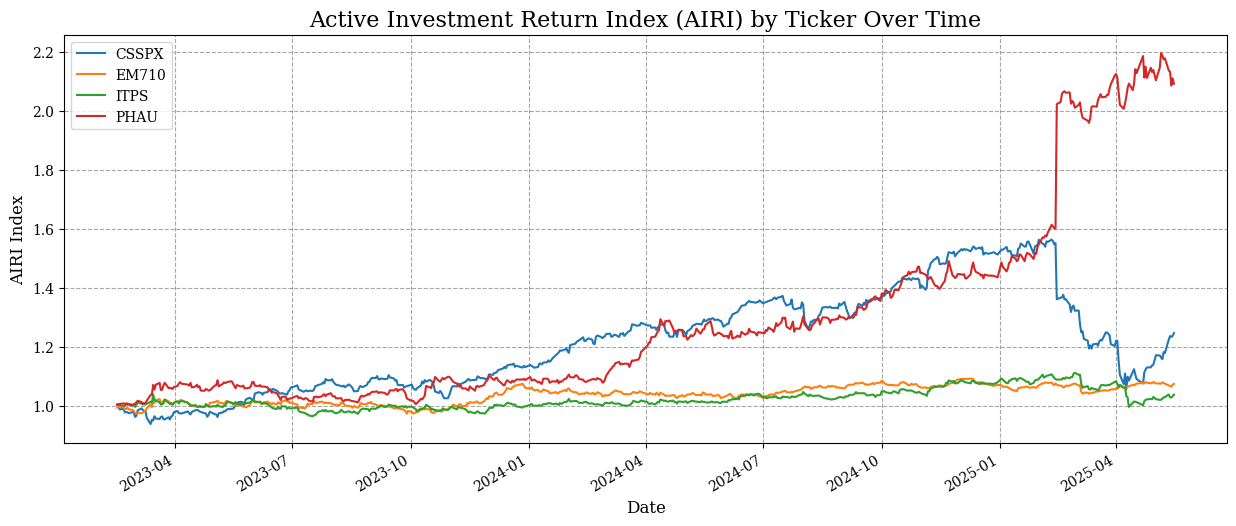

In [8]:
airi.plot(title='Active Investment Return Index (AIRI) by Ticker Over Time', 
          ylabel='AIRI Index', figsize=(15,6))

<Axes: title={'center': 'Total Return Index (TRI) by Ticker Over Time'}, xlabel='Date', ylabel='TRI Index'>

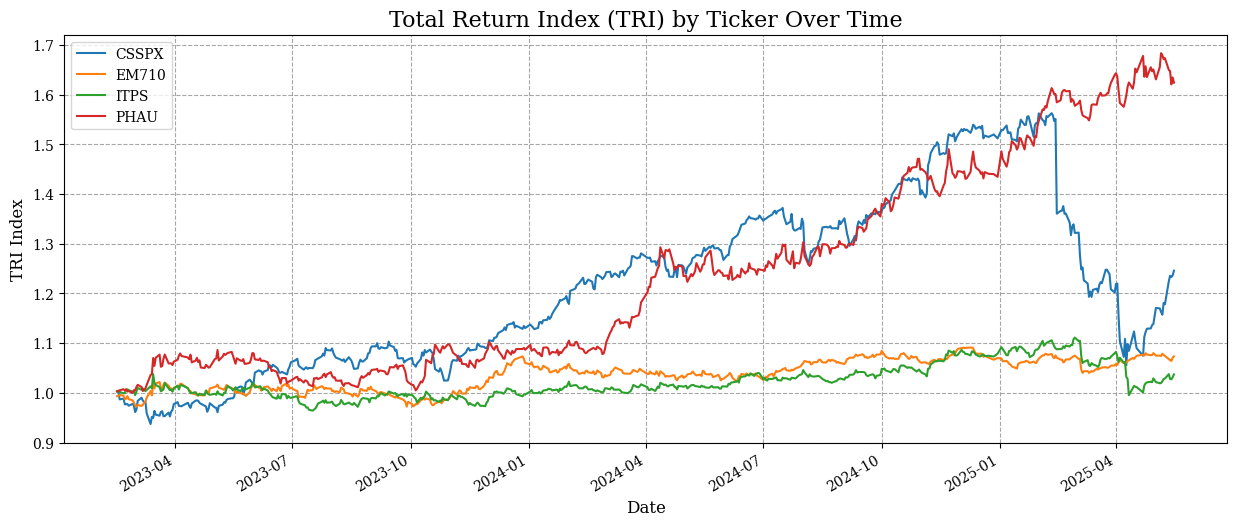

In [9]:
tri.plot(title='Total Return Index (TRI) by Ticker Over Time', 
          ylabel='TRI Index', figsize=(15,6))

#### E. Calculating Single Asset **Price-to-Fiscal Price Ratio**
To complete this section, I wanto to calculate the *Price-to-Fiscal Price Ratio*, a simple but powerful indicator of unrealized return on an asset position. It compares the current market price to the investor’s cost basis:
$$\text{Price-to-Fiscal Price Ratio} = \frac{\text{Current Market Price}}{\text{Fiscal Price}}$$

**Fiscal Price** reflects the average acquisition cost per share, including transaction fees (commissions).
- A ratio **> 1** indicates a **gain**; the asset is currently worth more than what was paid.
- A ratio **< 1** indicates a **loss**.

🔍 **Interpreting in Terms of Return**

To express this ratio as a **gross return**:
$$\text{Unrealized Ruturn} = \frac{\text{Price}}{\text{Fiscal Price}} -1$$
This return excludes realized gains/losses, dividends, or taxes, and focuses solely on how the market value has changed relative to the acquisition cost.

I compute the `fiscal_price` time series per each asset using the formula:

$$\text{Fiscal Price} = \frac{\text{Subscriptions + Costs}}{\text{Shares}}$$

​When applying this formula, it's important to account for cases where I completely close a position in a Ticker and later re-enter. In such situations, I need to reset the accumulated Subscriptions and Costs so that the `fiscal_price` reflects only the current holding period, not past ones.

Finally, I test the logic on a sample set of transactions to verify that the implementation works as expected.

In [10]:
# Loading the example set of transactions
excel_path = '../data/transactions_fiscalprice_test.xlsx'
transacts_test = load_transactions(excel_path=excel_path, sheet_name=0)

##### Fiscal Price Calculation
The **Fiscal Price** Trepresents the average cost of acquiring an asset (including commissions), tracked through distinct holding periods. Here's how it's computed:

1. **Filter Transactions by Ticker** from the transaction history to isolate its activity.

In [11]:
# 0. Define the ticker of interest
ticker = 'CSSPX'
# 1. Create a Filter for the Ticker Trasactions
mask= (transacts_test['Ticker'] == ticker)
# 2. Filter for a single ticker
df_ticker = transacts_test[mask].copy()
df_ticker

,Ticker,Type,Shares,Amount,Commissions,Taxes
Date,,,,,,
2023-02-15,CSSPX,BUY,63,25144.72,8.0,0.0
2025-02-14,CSSPX,BUY,21,13002.36,18.0,0.0
2025-02-28,CSSPX,SELL,-84,-50400.00,8.0,3000.0
2025-03-31,CSSPX,BUY,30,16302.90,8.0,0.0
2025-04-10,CSSPX,SELL,-30,-15833.00,8.0,0.0
2025-04-17,CSSPX,BUY,15,7470.60,8.0,0.0
2025-04-28,CSSPX,BUY,40,20701.60,8.0,0.0


2. **Track Cumulative Shares Held**

Compute the running total of shares over time. When this total returns to zero, it marks the end of a holding period and the beginning of a new one.

In [12]:
# Create the pd.Series of Shares Held Over Time
shares_held = df_ticker.Shares.cumsum()
shares_held.name = 'shares_held'
shares_held

Date
2023-02-15    63
2025-02-14    84
2025-02-28     0
2025-03-31    30
2025-04-10     0
2025-04-17    15
2025-04-28    55
Name: shares_held, dtype: int32

3. **Identify Reset Points**

These are moments when I have fully sold my position. A new fiscal price computation starts after each reset.

4. **Group Transactions by Holding Period**

Each reset-to-reset interval becomes a unique group for analysis.

In [13]:
# fiscal_price Reset_Points are when Shares_Held go to zero
reset_points = (shares_held == 0)
# From each Reset_Point starts the new Shares_Group on which calculating the Fiscal Price
share_groups = reset_points.cumsum()
share_groups.name = 'share_groups'
share_groups

Date
2023-02-15    0
2025-02-14    0
2025-02-28    1
2025-03-31    1
2025-04-10    2
2025-04-17    2
2025-04-28    2
Name: share_groups, dtype: int32

5. **Accumulate Costs and Shares Bought (BUY only)**

For each group, I sum the amounts and commissions cumulatively over time, and also track the total shares bought.

Here I take the `df_ticker` DataFrame with all transaction and subset it for only `BUY` transactions. Then I group transactions by the reset points to create independent "holding periods." Within each holding group (`groupby(share_groups)`), I compute cumulative sums of `Amount`, and `Commissions` to calculate the buying costs:

In [14]:
# calculating buying costs in each independent group of holding periods
buy_cost_groups = df_ticker[df_ticker['Type'] == 'BUY'].groupby(share_groups)[['Amount','Commissions']].cumsum()
buy_cost_groups = buy_cost_groups.sum(axis=1)
buy_cost_groups

Date
2023-02-15    25152.72
2025-02-14    38173.08
2025-03-31    16310.90
2025-04-17     7478.60
2025-04-28    28188.20
dtype: float64

I do the same to calculate the `shares_buyed_groups` that are the shares bought in each independent "holding period".

In [15]:
# calculating the shares bought in each independent group of holding periods
shares_buyed_groups = df_ticker[df_ticker['Type'] == 'BUY'].groupby(share_groups)['Shares'].cumsum()
shares_buyed_groups

Date
2023-02-15    63
2025-02-14    84
2025-03-31    30
2025-04-17    15
2025-04-28    55
Name: Shares, dtype: int32

6. **Compute Fiscal Price per Row**

Fiscal Price = (Amount + Commissions) / Shares Bought

This yields the average acquisition cost within each "holding period".

In [16]:
# calculating the fiscal price in each independent group of holding periods
fiscal_price = buy_cost_groups/shares_buyed_groups
fiscal_price.name = 'fiscal_price'
fiscal_price

Date
2023-02-15    399.249524
2025-02-14    454.441429
2025-03-31    543.696667
2025-04-17    498.573333
2025-04-28    512.512727
Name: fiscal_price, dtype: float64

In [17]:
# outer joining shares held and fiscal prices
df_fiscal_price = pd.concat([shares_held,fiscal_price], axis=1)
df_fiscal_price

,shares_held,fiscal_price
Date,,
2023-02-15,63,399.249524
2025-02-14,84,454.441429
2025-02-28,0,NaN
2025-03-31,30,543.696667
2025-04-10,0,NaN
2025-04-17,15,498.573333
2025-04-28,55,512.512727


7. **Forward Fill Logic**
- If the investor is still holding shares (shares_held > 0), the last known fiscal price is forward-filled.
- If not holding (shares = 0), the fiscal price is set to zero.

In [18]:
# First, forward fill fiscal_price *only* where shares_held > 0
ffill_col = df_fiscal_price['fiscal_price'].where(df_fiscal_price['shares_held'] > 0).ffill()

# Now, fill NaNs: use forward-filled values where shares_held > 0, else 0
df_fiscal_price['fiscal_price_filled'] = np.where(df_fiscal_price['fiscal_price'].isna(),
                                         np.where(df_fiscal_price['shares_held'] > 0, ffill_col, 0),
                                         df_fiscal_price['fiscal_price'])
df_fiscal_price

,shares_held,fiscal_price,fiscal_price_filled
Date,,,
2023-02-15,63,399.249524,399.249524
2025-02-14,84,454.441429,454.441429
2025-02-28,0,NaN,0.000000
2025-03-31,30,543.696667,543.696667
2025-04-10,0,NaN,0.000000
2025-04-17,15,498.573333,498.573333
2025-04-28,55,512.512727,512.512727


In [19]:
df_fiscal_price.drop(labels=['shares_held','fiscal_price'], axis=1, inplace=True)
df_fiscal_price.rename(columns={'fiscal_price_filled':'fiscal_price'}, inplace=True)
df_fiscal_price

,fiscal_price
Date,
2023-02-15,399.249524
2025-02-14,454.441429
2025-02-28,0.000000
2025-03-31,543.696667
2025-04-10,0.000000
2025-04-17,498.573333
2025-04-28,512.512727


8. **Align with Daily Asset Index**

The resulting fiscal price series is reindexed to match the asset’s daily price time series, ensuring consistency for further analysis or plotting.

In [20]:
# Reindex to the asset time series index (daily frequency)
idx = assets['CSSPX'].index
df_fiscal_price = df_fiscal_price.reindex(idx, method='ffill')
df_fiscal_price.tail()

,fiscal_price
Date,
2025-05-12,512.512727
2025-05-13,512.512727
2025-05-14,512.512727
2025-05-15,512.512727
2025-05-16,512.512727


I wrap this code in one reusable function `calculate_fiscal_prices()` and test it on my real portfolio transactions in the `df_transacts` DataFrame.

In [21]:
def calculate_fiscal_price(transactions, assets, ticker):
    """
    Calculate and assign the fiscal price for a single asset based on its transaction history.

    The fiscal price is computed by tracking the average cost (including commissions) of bought shares 
    within distinct holding periods (reset when holdings drop to zero).

    Parameters:
        transactions (pd.DataFrame): All asset transactions. Must include columns: 
                                     ['Ticker', 'Type', 'Shares', 'Amount', 'Commissions'].
        assets (dict): Dictionary of asset DataFrames keyed by ticker.
                       Each DataFrame must have a datetime index (daily frequency).
        ticker (str): The asset ticker for which the fiscal price is computed.

    Returns:
        pd.Series: The calculated fiscal price time series aligned to the asset's date index.
    """
    # Filter for ticker
    df_ticker = transactions[transactions['Ticker'] == ticker].copy()
    
    # Shares held over time
    shares_held = df_ticker['Shares'].cumsum()
    shares_held.name = 'shares_held'
    
    # Identify reset points where holdings drop to zero
    reset_points = (shares_held == 0)
    share_groups = reset_points.cumsum()
    share_groups.name = 'share_groups'

    # Cost of BUY transactions grouped cumulatively
    buy_cost_groups = (
        df_ticker[df_ticker['Type'] == 'BUY']
        .groupby(share_groups)[['Amount', 'Commissions']]
        .cumsum()
        .sum(axis=1)
    )

    # Shares bought per group
    shares_bought_groups = (
        df_ticker[df_ticker['Type'] == 'BUY']
        .groupby(share_groups)['Shares']
        .cumsum()
    )

    # Fiscal price per group
    fiscal_price = (buy_cost_groups / shares_bought_groups)
    fiscal_price.name = 'fiscal_price'

    # Combine and conditionally forward-fill fiscal price
    df_fiscal_price = pd.concat([shares_held, fiscal_price], axis=1)

    # Forward fill only where shares are held
    ffill_col = df_fiscal_price['fiscal_price'].where(df_fiscal_price['shares_held'] > 0).ffill()

    # Fill NaNs accordingly
    df_fiscal_price['fiscal_price'] = np.where(
        df_fiscal_price['fiscal_price'].isna(),
        np.where(df_fiscal_price['shares_held'] > 0, ffill_col, 0),
        df_fiscal_price['fiscal_price']
    )

    # Drop helper column
    df_fiscal_price.drop(columns=['shares_held'], inplace=True)

    # Align to asset's daily index
    df_fiscal_price = df_fiscal_price.reindex(assets[ticker].index, method='ffill')

    # Assign to asset DataFrame
    assets[ticker]['Fiscal_Price'] = df_fiscal_price['fiscal_price']

    return assets[ticker]['Fiscal_Price']

In [22]:
# example usage of the calculate_fiscal_price function for all assets
fiscal_prices={}
for asset in assets.keys():
     fiscal_prices[asset] = calculate_fiscal_price(transactions=df_transacts,
                                                   assets=assets,
                                                   ticker=asset)

I can now create the DataFrame with the series of all assets *Price to Fiscal-Price Ratios* and plot them over time:

In [23]:
price_to_fiscal_price_ratio = []
for asset in assets.keys():
    price_to_fiscal_price_ratio.append(assets[asset].Price/fiscal_prices[asset])
price_to_fiscal_price_ratio = pd.concat(price_to_fiscal_price_ratio,axis=1)
price_to_fiscal_price_ratio.columns = assets.keys()
price_to_fiscal_price_ratio.tail(2)

,CSSPX,EM710,ITPS,PHAU
Date,,,,
2025-05-15,1.236133,1.070518,1.031379,1.646843
2025-05-16,1.245727,1.073393,1.037006,1.632531


In [24]:
print('Returns (%) per Asset as of latest market data:',
      price_to_fiscal_price_ratio.iloc[-1].name.strftime('%Y-%m-%d'))
((price_to_fiscal_price_ratio.iloc[-1] - 1)*100).round(2)

Returns (%) per Asset as of latest market data: 2025-05-16


CSSPX    24.57
EM710     7.34
ITPS      3.70
PHAU     63.25
Name: 2025-05-16 00:00:00, dtype: float64

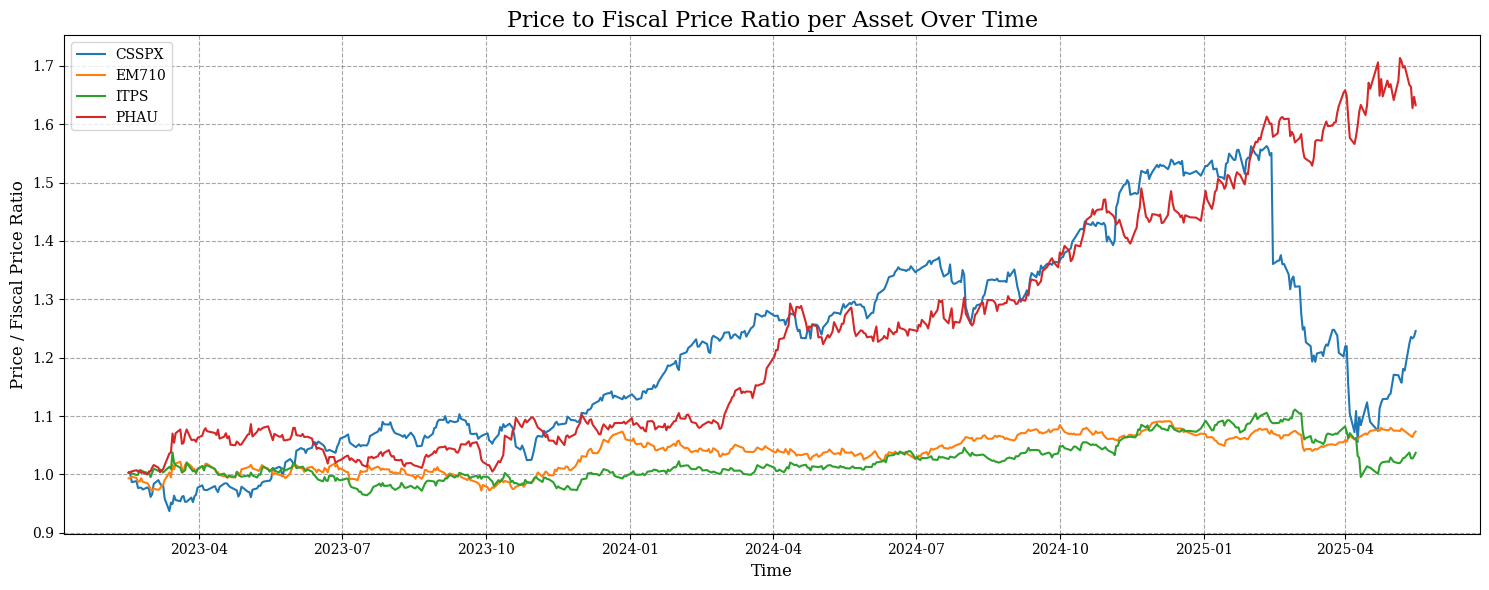

In [25]:
from utils import plot_timeseries
plot_timeseries(
    time_series_data=price_to_fiscal_price_ratio,
    columns_to_plot=price_to_fiscal_price_ratio.columns,
    title='Price to Fiscal Price Ratio per Asset Over Time',
    ylabel='Price / Fiscal Price Ratio',
    xlabel='Time',
    legend_loc='upper left',
    figsize=(15,6)
    )

### Summary
In this notebook, I covered the following key points:
- Computed **Total Return**, **Annual Return**, **Annual Volatility**, and **Sharpe Ratio** for each asset in the portfolio.
- Identified the **Maximum Drawdown** and corresponding drawdown periods for each asset since its entry into the portfolio.
- Visualized the evolution of the **Active Investment Return Index (AIRI)** and the **Total Return Index (TRI)** over time for each asset.
- Calculated the **Price-to-Fiscal Price Ratio** for each asset to assess unrealized gains or losses relative to acquisition cost.

Additionally, I defined the function `calculate_fiscal_price()`, which returns a `pd.Series` representing the fiscal price time series of a given asset, aligned to the asset’s daily price index.

The below summary table recaps the 3 metrics used to evaluate each asset performance.

#### Comparison: Fiscal Price Ratio vs. AIRI and TRI

| Metric                          | What It Measures                                      | Includes Reinvested Flows | Reflects Individual Costs | Use Case                                      |
|-------------------------------|--------------------------------------------------------|----------------------------|----------------------------|-----------------------------------------------|
| **Price / Fiscal Price**       | Gain/loss on currently held shares based on acquisition cost | ❌                         | ✅ (Commissions included in Fiscal Price) | Snapshot of position-level profitability      |
| **TRI (Total Return Index)**   | Total return from all cash inflows vs. total costs     | ✅ (Dividends + Redemptions) | ✅ (All Subscriptions, Commissions, Taxes) | Benchmark-style long-term return indicator    |
| **AIRI (Active Investment Return Index)** | Unrealized return on capital currently invested       | ❌ (Excludes Redemptions & Dividends) | ✅ (Net of all inflows/outflows)         | Performance of current capital at risk        |

---

#### ✅ Clarification:

- **TRI** uses:  

  $
  \text{TRI} = \frac{\text{Market Value} + \text{Redemptions} + \text{Dividends}}{\text{Subscriptions} + \text{Commissions} + \text{Taxes}}
  $

  → Captures all cash effects, including divestments and distributions.

- **AIRI** uses:  

  $
  \text{AIRI} = \frac{\text{Market Value}}{\text{Net Costs}} \quad \text{where Net Costs} = \text{Subscriptions} + \text{Costs} - \text{Redemptions} - \text{Dividends}
  $
  
  → Focuses only on capital currently invested, excluding what has already been recovered.

- **Price / Fiscal Price**:

  $
  \text{Unrealized Return} = \frac{\text{Current Price}}{\text{Fiscal Price}} - 1
  $
  
  → Reflects the relative gain/loss for currently held shares based on acquisition cost.